To explore the peak finding in the presence of higher modes using two methods

1. Peaks where all the modes are included, using the frobenius matrix $\phi_{c}^{lm}$
2. Using just the dominant mode peaks - $\phi_{c}^{22}$

We want to see how close each of these

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pycbc.inference.models.gaussian_noise import GaussianNoise
from pycbc.inference.models.marginalized_gaussian_noise import MarginalizedHMPhase
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.psd.analytical import aLIGOZeroDetHighPower
from pycbc.waveform.utils import apply_fd_time_shift
import scipy

/Users/vikasjadhav/anaconda3/envs/hmnumerical/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
## Helper functions
df = 1/24
psd = aLIGOZeroDetHighPower(length=int((1024/df)+1),
                                                 delta_f = df,
                                                 low_freq_cutoff = 20)

psd_network = { 'hl' :{'H1': psd,'L1': psd},
        'h': {'H1': psd},
         'l': {'L1': psd} }

det_network = {
    'hl' : {'H1': Detector('H1'),'L1': Detector('L1')},
    'h' : {'H1': Detector('H1')},
    'l' : {'L1': Detector('L1')}
}

low_freq_network = {
    'hl' : {'H1': 20,'L1': 20},
    'h' : {'H1':20},
    'l' : {'L1': 20}
}

##Helper functions

def generate_data(network,**params):
    data = {}
    for ifo in det_network[network]:
        hp,hc = get_fd_waveform(delta_f = df,**params)
        fp, fc = det_network[network][ifo].antenna_pattern(params['ra'],
                             params['dec'],
                             params['polarization'],
                             params['tc'])
        dt = det_network[network][ifo].time_delay_from_earth_center(params['ra'],
                                            params['dec'],
                                            params['tc'])
        tshift = dt + params['tc']
        data[ifo] = apply_fd_time_shift(fp*hp + fc*hc,
                                                             tshift)
        data[ifo].resize(len(psd))
    return data

def log_rel_err(log_approx, log_true):
    """
    Calculates absolute relative error between approx and true values
    |approx-true|/true

    """
    delta = log_approx - log_true
    if delta > 0 :
        return np.log10(np.e**(delta)-1)
    if delta < 0 :
        return np.log10(1- np.e**(delta))

def brute_marg(cls_instance,
               param_min,param_max,nsamples):
    
    samples = np.linspace(param_min,
                          param_max,
                          nsamples)
    loglr_samples = np.zeros(len(samples))
    for i in range(len(samples)):
        ##Currently hard coded to marginalise coa_phase
        cls_instance.update(coa_phase=samples[i])
        loglr_samples[i] = cls_instance.loglr
    marg_loglr = scipy.special.logsumexp(loglr_samples) - np.log(nsamples)
    return {'margloglr' : marg_loglr,
            'phi_samples' : samples,
            'loglr_samples' : loglr_samples}

def rvs_marg(cls_instance,
             param_min, param_max, nsamples):
    
    rvs = np.random.rand(nsamples)
    samples = param_min + rvs*(param_max - param_min)
    loglr_samples = np.zeros(nsamples)
    for i in range(nsamples):
        cls_instance.update(coa_phase = samples[i])
        loglr_samples[i] = cls_instance.loglr
    marg_loglr = scipy.special.logsumexp(loglr_samples) - np.log(nsamples)
    return {'margloglr' : marg_loglr,
            'phi_samples' : samples,
            'loglr_samples' : loglr_samples}


def create_static(param):
    static = param.copy()
    _ = static.pop('coa_phase')
    return static

def draw_inj_samples(inj_file, n):
    param_dict = {}
    for p in inj_file.keys():
        param_dict[p] = inj_file[p][n]
    for sp in inj_file.attrs['static_args']:
        param_dict[sp] = inj_file.attrs[sp]
    return param_dict

def lr_surface(phi,cls_instance):
    cls_instance.update(coa_phase=phi)
    return np.e**(cls_instance.loglr)

def peak_loglr(cls_instance,true_phi):
    cls_instance.update(coa_phase = true_phi)
    return cls_instance.loglr

def rescaled_lr_surface(phi,cls_instance,true_phi):
    max_loglr = peak_loglr(cls_instance,true_phi)
    cls_instance.update(coa_phase = phi)
    return np.e**(cls_instance.loglr - max_loglr)
 

#def quad_int(cls_instace,param_min, param_max,true_phi):
#    I = scipy.integrate.quad(rescaled_lr_surface,param_min,param_max,args = (cls_instace,true_phi))
#    logscale = peak_loglr(cls_instace,true_phi)
#    return np.log(I[0]) + logscale - np.log(2*np.pi)

def quad_int(cls_instace,param_min, param_max):
    I = scipy.integrate.quad(lr_surface,param_min,param_max,args = (cls_instace))
    return np.log(I[0]) - np.log(2*np.pi)



In [3]:
network = 'h'
variable_params = {'coa_phase'}
inj_file = h5py.File('../../injections.hdf', 'r')

In [4]:
N = 1000

In [5]:
hm_dom_peaks = []
hm_all_peaks = []
true_peak = []
mode_fraction = []
for i in range(N):
    param = draw_inj_samples(inj_file,i)
    param['mode_array'] = '22 33'
    true_peak.append(param['coa_phase'])
    data = generate_data(network=network,**param)
    hm_all = MarginalizedHMPhase(variable_params=variable_params,
                               data=data,
                               low_frequency_cutoff=low_freq_network[network],
                               psds=psd_network[network],
                               static_params=create_static(param))
    hm_dominant = MarginalizedHMPhase(variable_params=variable_params,
                               data=data,
                               low_frequency_cutoff=low_freq_network[network],
                               psds=psd_network[network],
                               static_params=create_static(param),
                               dominant_mode_peak=True)
    hm_all.update(coa_phase = 0)
    hm_dominant.update(coa_phase = 0)
    hm_all.loglr
    hm_dominant.loglr
    hm_all_peaks.append(hm_all.peaks)
    hm_dom_peaks.append(hm_dominant.peaks)
    if param['mode_array'] == '22 33':
        mode_fraction.append(
            np.abs(hm_all.shm[3])/np.abs(hm_all.shm[2]+hm_all.shm[3])
        )
    if param['mode_array'] == '22':
        mode_fraction.append(
            np.abs(hm_dominant.shm[2])
        )

using analytic approximation
0.00042287493124604225
using analytic approximation
0.0003037499263882637
using analytic approximation
0.0003599999472498894
using analytic approximation
0.0003234159667044878
using analytic approximation
0.00033670803532004356
using analytic approximation
0.00028912490233778954
using analytic approximation
0.00035562505945563316
using analytic approximation
0.00033483305014669895
using analytic approximation
0.0003107080701738596
using analytic approximation
0.00027670920826494694
using analytic approximation
0.00033208285458385944
using analytic approximation
0.00025420798920094967
using analytic approximation
0.0002975000534206629
using analytic approximation
0.0002617090940475464
using analytic approximation
0.00032070791348814964
using analytic approximation
0.0002734169829636812
using analytic approximation
0.0003118340391665697
using analytic approximation
0.0002512501087039709
using analytic approximation
0.00029874988831579685
using analytic approx

In [6]:
print(hm_dom_peaks[0])
print(hm_all_peaks[0])
print(true_peak[0])
#print(mode_fraction[0])

[6.24855915 1.53617017 3.10696649 4.67776282]
[3.1065816  1.52515221 6.24891837 4.68882119]
6.2489183803442305


In [7]:
def peak_error(peaks,true_phi):
    return np.min(np.abs(peaks-true_phi))


In [8]:
error_all = np.zeros(N)
error_dom = np.zeros(N)
for i in range(N):
    error_all[i] = peak_error(hm_all_peaks[i],true_peak[i])
    error_dom[i] = peak_error(hm_dom_peaks[i],true_peak[i])

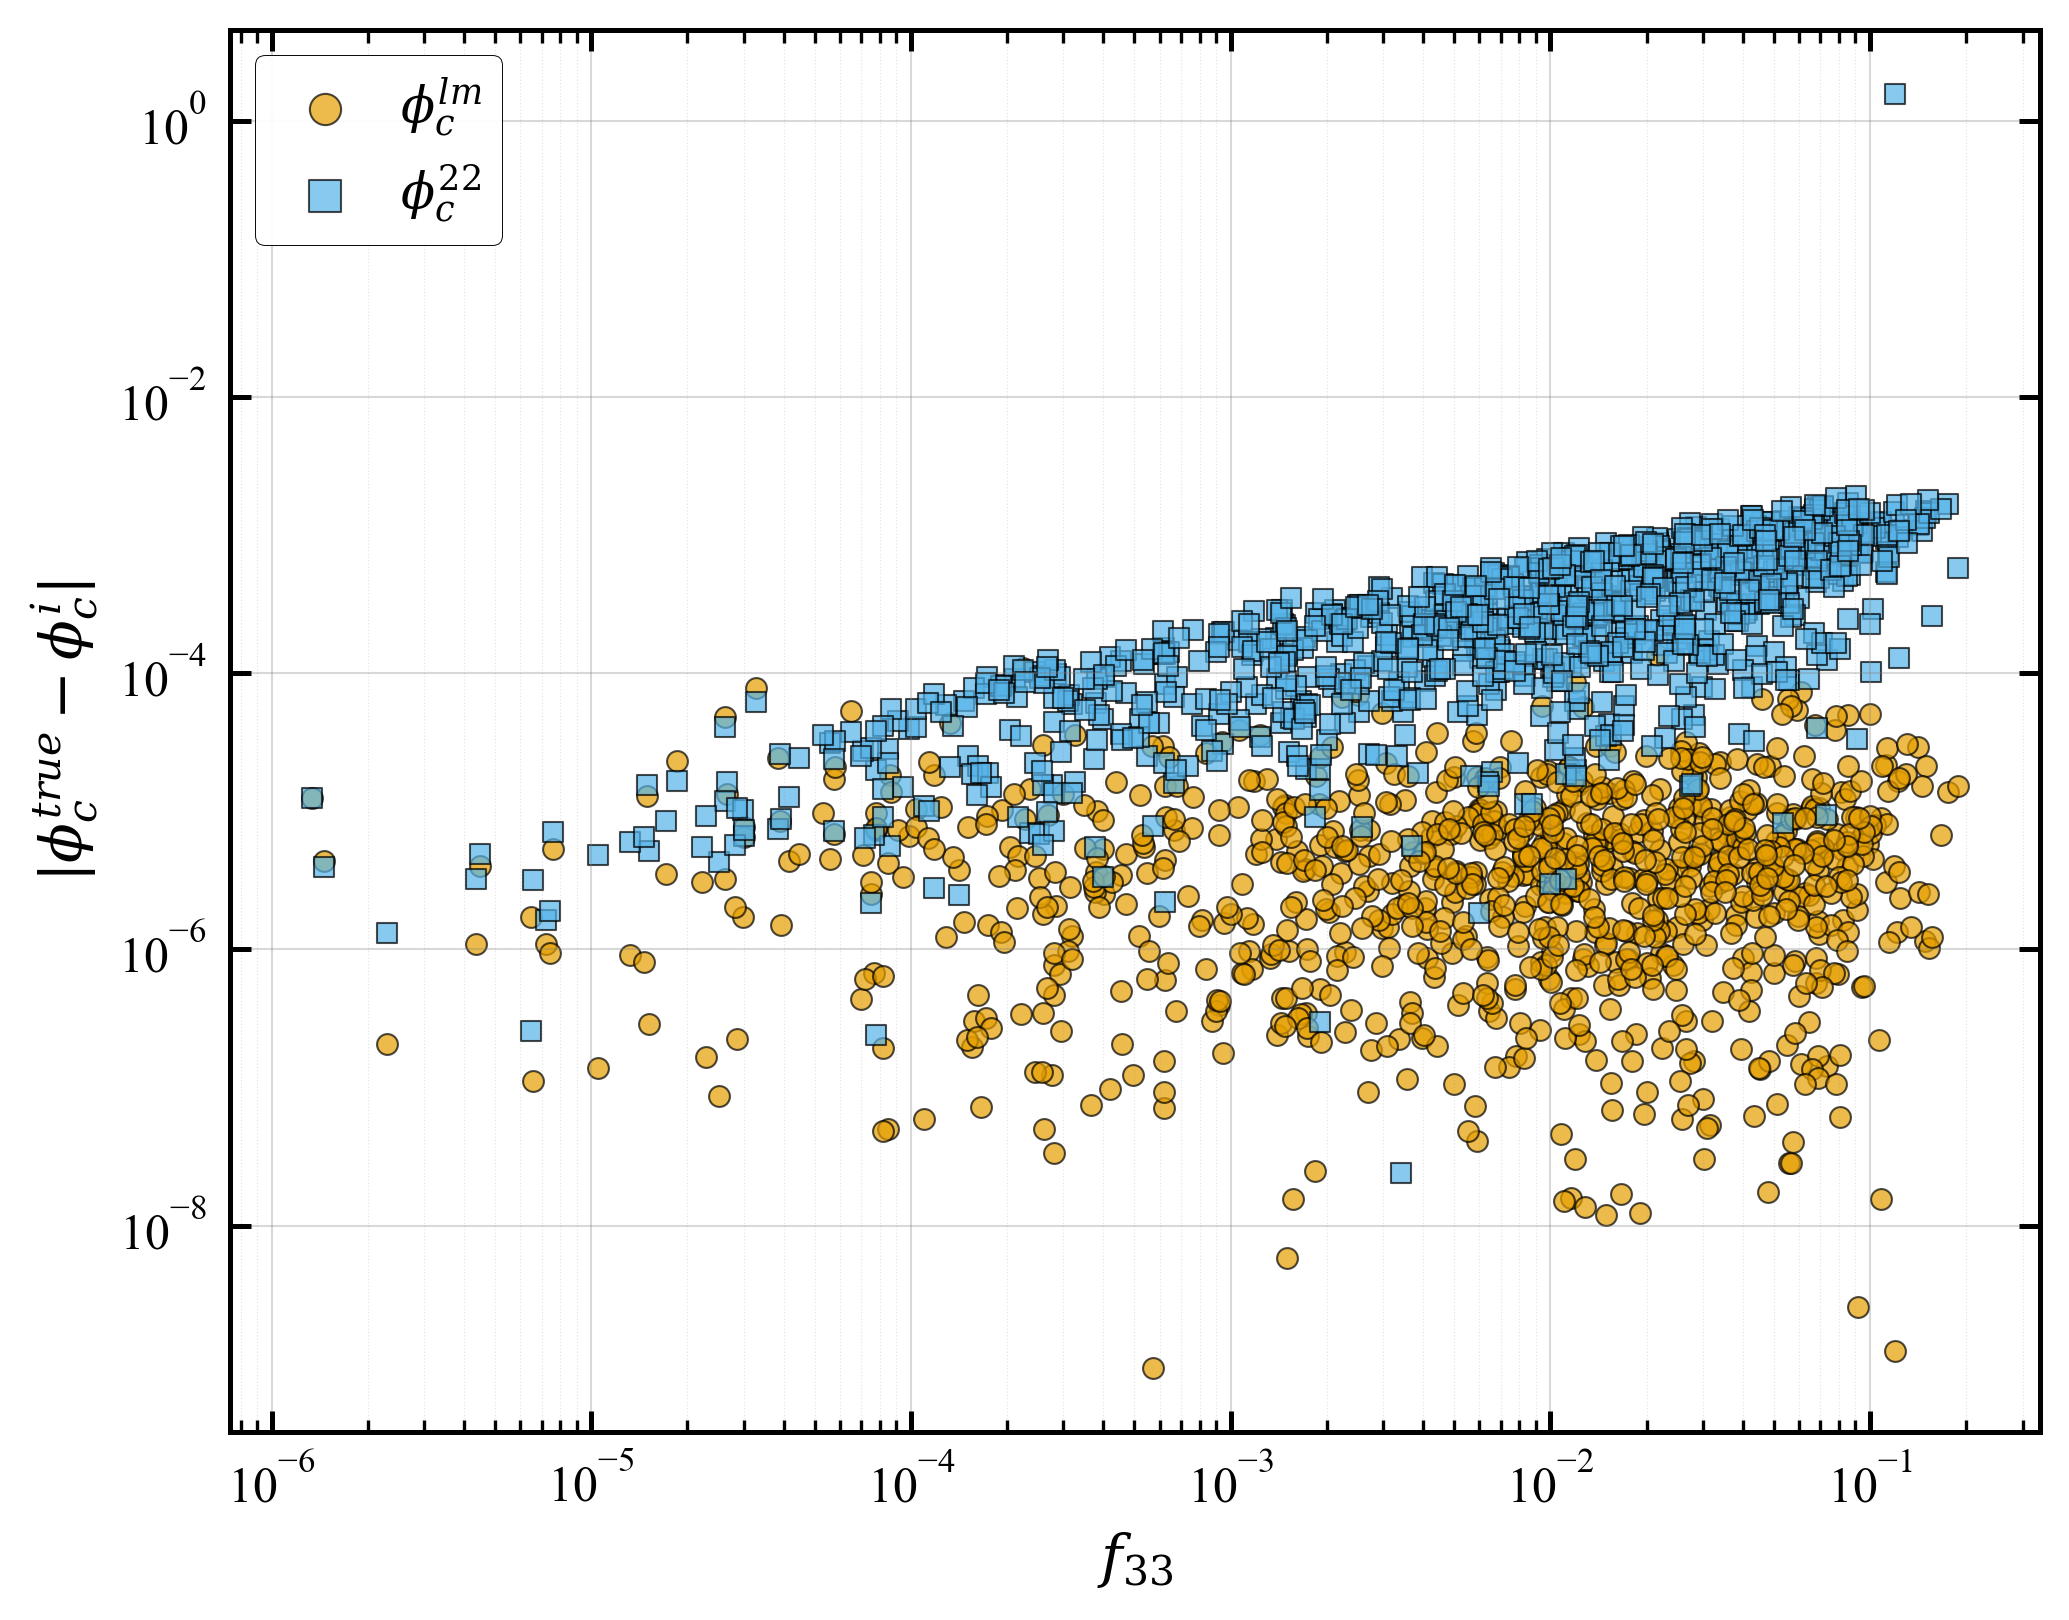

In [13]:
import matplotlib as mpl

# Set publication-quality style
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3

# Create figure with appropriate size for journal (single column ~3.5", double column ~7")
fig, ax = plt.subplots(figsize=(7, 5.5), dpi=300)

colors = ['#E69F00', '#56B4E9']  
markers = ['o', 's']
size = 25

ax.scatter(
    mode_fraction, error_all,
    label = r'$\phi_{c}^{lm}$',
    s = size, alpha=0.7,
    color = colors[0],
    marker=markers[0],
    edgecolors='black',
    linewidths=0.5
)

ax.scatter(
    mode_fraction, error_dom,
    label = r'$\phi_{c}^{22}$',
    s = size, alpha=0.7,
    color = colors[1],
    marker=markers[1],
    edgecolors='black',
    linewidths=0.5
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{33}$', fontsize=14)
ax.set_ylabel(r'$|\phi_{c}^{true} - \phi_{c}^{i}|$', fontsize=14)

ax.tick_params(labelsize=12, which='both', direction='in', top=True, right=True)

ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.3, color='gray')
ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.2, color='gray')

ax.legend(loc='best', frameon=True, framealpha=0.95, 
          edgecolor='black', fontsize=12, 
          markerscale=1.5, handletextpad=0.5)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()

plt.show()

# fig.savefig('figure.pdf', dpi=300, bbox_inches='tight', format='pdf')
fig.savefig('peak_finding.png', dpi=300, bbox_inches='tight')